# Third assignment: Social contagion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections, itertools

from random import choice
from networkx.algorithms import community

#from networkx.algorithms.community.quality import modularity
#from networkx.algorithms import community
#from networkx.algorithms.community import greedy_modularity_communities

In [2]:
def init_labels():
    labels={}
    for node in G.nodes():
        labels[node] = 'b'
    return labels

def susceptibleList(labeledNodes):
    return [k for k,v in labeledNodes.items() if v=='b']

def spread_contagion(labeledNodes, decisionPO):
    i = 1
    
    while True:
        current = list(labeledNodes.values())
        susc = susceptibleList(labeledNodes)
        
        for node in susc:
            
            edgelist = []
            for pair in list(G.edges()):
                if node not in pair:
                    continue
                edgelist.append(pair[1] if pair[0]==node else pair[0])
            
            num_neigb = len(edgelist)
            infct_neigb = len([friend for friend in edgelist if labeledNodes[friend]=='r'])
                    
            if infct_neigb/num_neigb >= decisionPO:
                labeledNodes[node]='r'
                susc.remove(node)

        plt.figure(figsize=(15,8))
        plt.title("iteration {}: #Susceptible:{}, #Infected:{}"
                  .format(i,len(susc),len(labeledNodes)-len(susc)))
        nx.draw_networkx(G, pos, node_color=labeledNodes.values(), font_size=10, node_size=80) 

        if current==list(labeledNodes.values()): break
        
        i+=1

## 1. Toy Graph - Davis_southern_women_graph

In [3]:
G = nx.davis_southern_women_graph()
pos = nx.spring_layout(G)

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Number of nodes: 32
Number of edges: 89


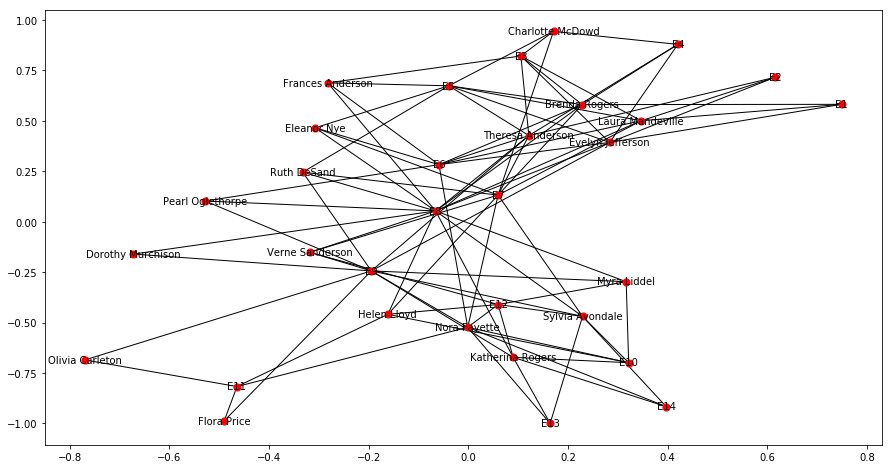

In [4]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### Payoff matrix definition

In [5]:
equal_po = np.eye(2)
q_equal = equal_po[1,1]/(equal_po[0,0]+equal_po[1,1])

In [6]:
a_po = equal_po + [[1,0],[0,0]]
q_a = a_po[1,1]/(a_po[0,0]+a_po[1,1])

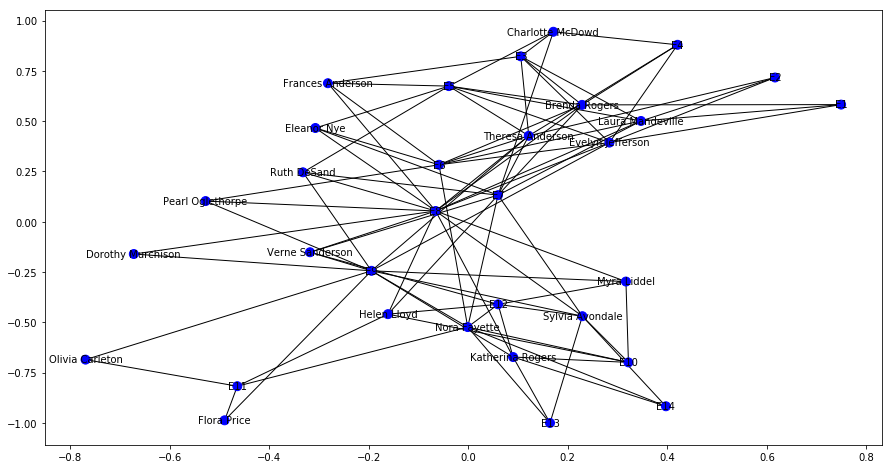

In [7]:
labels = init_labels()

plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,node_color=labels.values(),font_size=10,node_size=80)

## Random infection 

In [8]:
def random_infection(labeledNodes):
    susc = susceptibleList(labeledNodes)
    newInfected = choice(susc)
    labels[newInfected] = 'r'
    return newInfected

In [9]:
labels = init_labels()

In [10]:
random_infection(labels)

'E3'

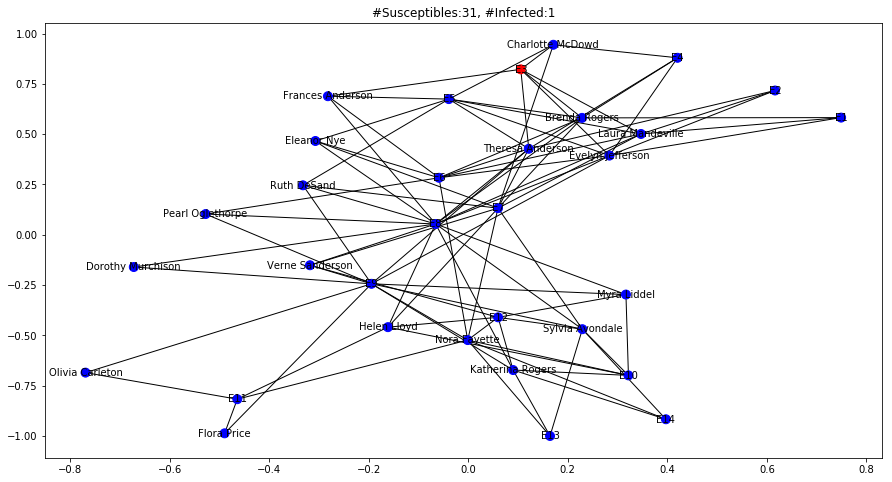

In [14]:
susceptibles = susceptibleList(labels)

plt.figure(figsize=(15,8))
plt.title("#Susceptibles:{}, #Infected:{}".format(len(susceptibles),len(labels)-len(susceptibles)))
nx.draw_networkx(G,pos,node_color=labels.values(),font_size=10,node_size=80)

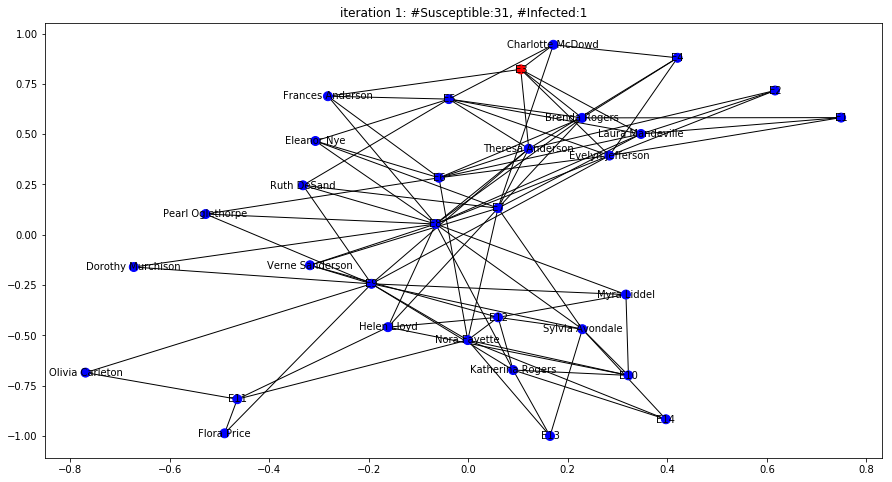

In [15]:
spread_contagion(labels, q_equal)

## Nodes-measure guided Infections

In [34]:
def metric_infection(labeledNodes, metricFunction):
    susc = susceptibleList(labeledNodes)
    ranked_closeness = sorted(metricFunction(G).items(), key=lambda pair:pair[1], reverse=True)
    
    for node,_ in ranked_closeness:
        if node in susc:
            labeledNodes[node]='r'
            break
    
    return node

### Closeness derived infection

In [35]:
sorted(nx.closeness_centrality(G).items(), key=lambda pair:pair[1], reverse=True)

[('E8', 0.5961538461538461),
 ('E9', 0.5535714285714286),
 ('Evelyn Jefferson', 0.5166666666666667),
 ('Theresa Anderson', 0.5166666666666667),
 ('Nora Fayette', 0.5166666666666667),
 ('E7', 0.5166666666666667),
 ('Sylvia Avondale', 0.5),
 ('E6', 0.484375),
 ('Laura Mandeville', 0.4696969696969697),
 ('Brenda Rogers', 0.4696969696969697),
 ('Katherina Rogers', 0.4696969696969697),
 ('Helen Lloyd', 0.4696969696969697),
 ('Ruth DeSand', 0.45588235294117646),
 ('Verne Sanderson', 0.45588235294117646),
 ('Myra Liddel', 0.44285714285714284),
 ('Frances Anderson', 0.4305555555555556),
 ('Eleanor Nye', 0.4305555555555556),
 ('Pearl Oglethorpe', 0.4305555555555556),
 ('Dorothy Murchison', 0.4189189189189189),
 ('E5', 0.4189189189189189),
 ('E3', 0.3974358974358974),
 ('E12', 0.3974358974358974),
 ('Charlotte McDowd', 0.3875),
 ('E10', 0.3875),
 ('Olivia Carleton', 0.3780487804878049),
 ('Flora Price', 0.3780487804878049),
 ('E4', 0.3780487804878049),
 ('E11', 0.3780487804878049),
 ('E1', 0.369

In [36]:
labels = init_labels()

In [49]:
metric_infection(labels, nx.closeness_centrality)

'Nora Fayette'

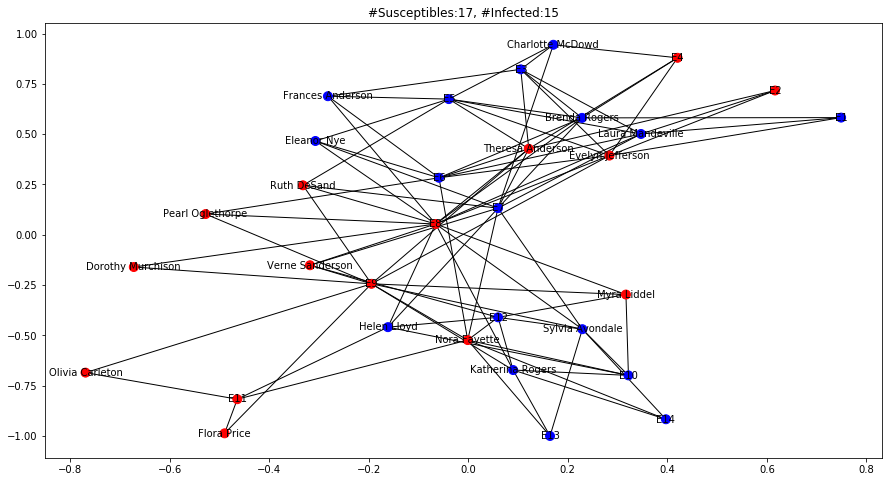

In [50]:
susceptibles = susceptibleList(labels)

plt.figure(figsize=(15,8))
plt.title("#Susceptibles:{}, #Infected:{}".format(len(susceptibles),len(labels)-len(susceptibles)))
nx.draw_networkx(G,pos,node_color=labels.values(),font_size=10,node_size=80)

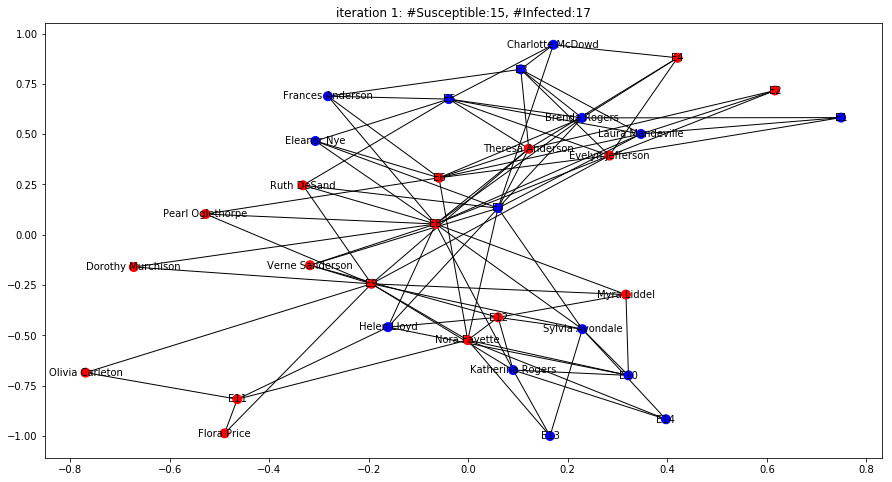

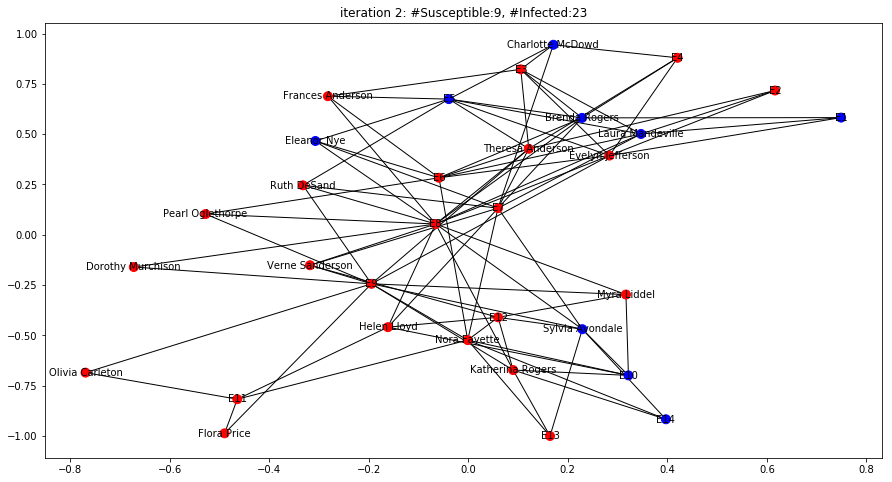

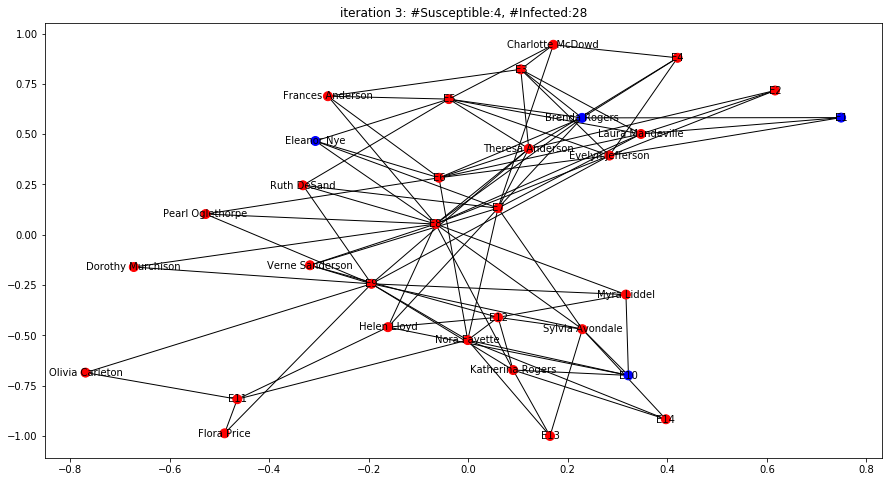

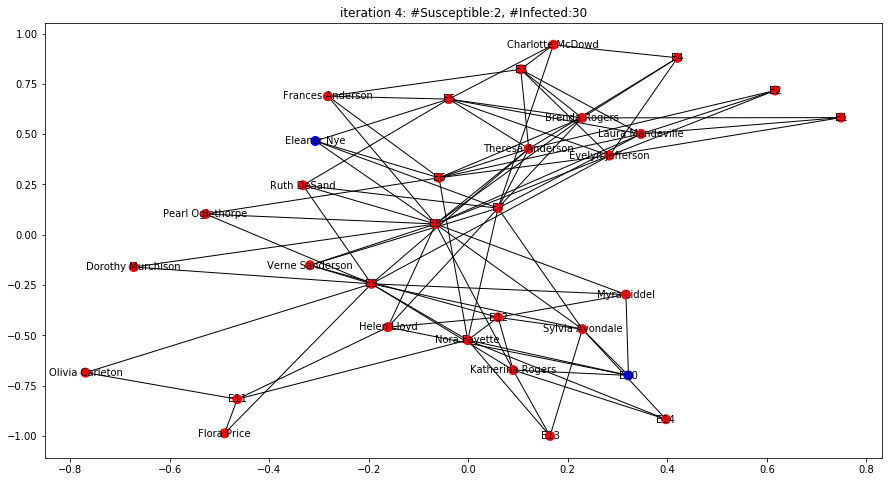

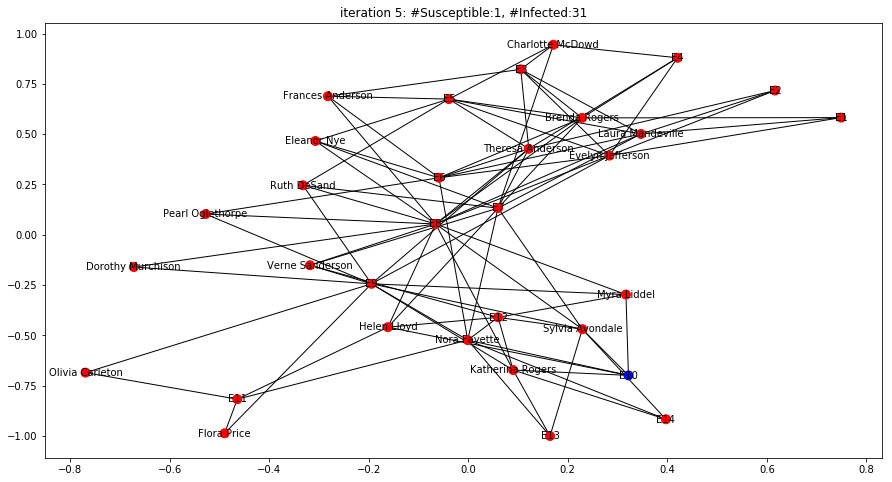

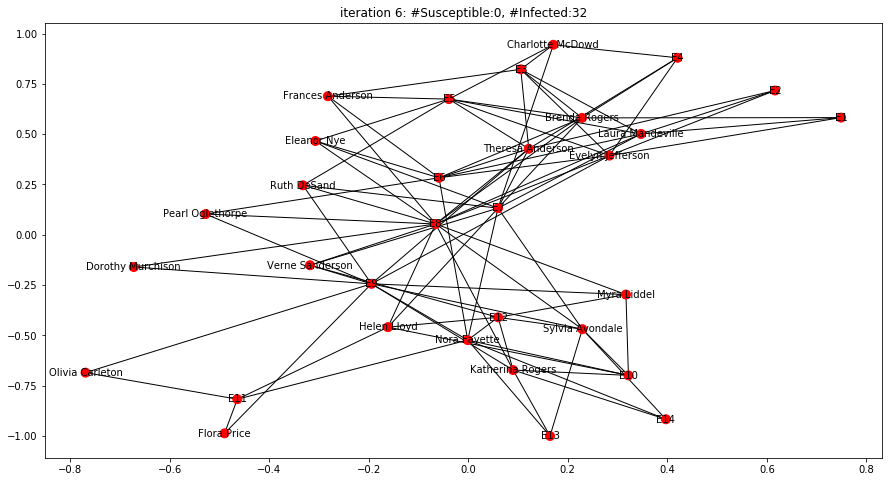

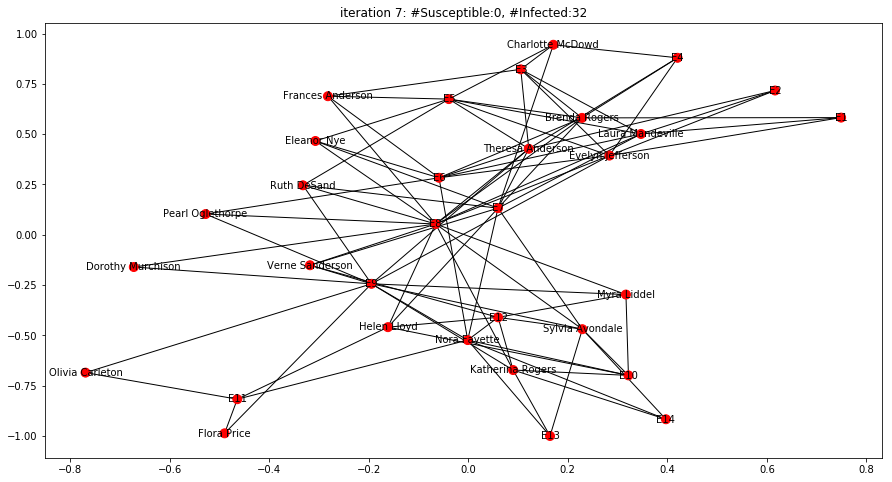

In [51]:
spread_contagion(labels, q_equal)

### Betweenness derived infection

In [52]:
sorted(nx.betweenness_centrality(G).items(), key=lambda pair:pair[1], reverse=True)

[('E8', 0.23700300426238308),
 ('E9', 0.21920891071174742),
 ('E7', 0.1258812653738273),
 ('Nora Fayette', 0.10858130346049079),
 ('Evelyn Jefferson', 0.09243053952845212),
 ('Theresa Anderson', 0.08382717212549207),
 ('Sylvia Avondale', 0.06862488078028632),
 ('E6', 0.06319868906402719),
 ('Laura Mandeville', 0.04914868366576943),
 ('Brenda Rogers', 0.04735814390994237),
 ('Katherina Rogers', 0.0453256463296124),
 ('Helen Lloyd', 0.0405644200615806),
 ('E5', 0.03664061940065164),
 ('E11', 0.01911560576755823),
 ('E3', 0.017714891753424267),
 ('E12', 0.017588323198345388),
 ('Ruth DeSand', 0.01606125402625199),
 ('Myra Liddel', 0.01564136563963574),
 ('Verne Sanderson', 0.015060776907855697),
 ('E10', 0.011122410270192064),
 ('Frances Anderson', 0.010253510918225078),
 ('Charlotte McDowd', 0.010140350205990675),
 ('Eleanor Nye', 0.009037924491193493),
 ('E4', 0.007486726470019202),
 ('Pearl Oglethorpe', 0.006507836308894933),
 ('Olivia Carleton', 0.00483710716158534),
 ('Flora Price', 

In [53]:
labels = init_labels()

In [62]:
metric_infection(labels, nx.betweenness_centrality)

'Evelyn Jefferson'

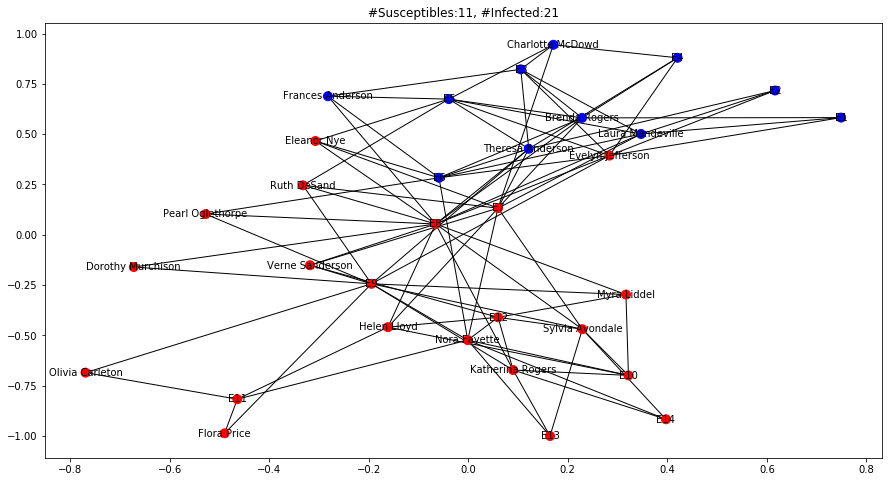

In [63]:
susceptibles = susceptibleList(labels)

plt.figure(figsize=(15,8))
plt.title("#Susceptibles:{}, #Infected:{}".format(len(susceptibles),len(labels)-len(susceptibles)))
nx.draw_networkx(G,pos,node_color=labels.values(),font_size=10,node_size=80)

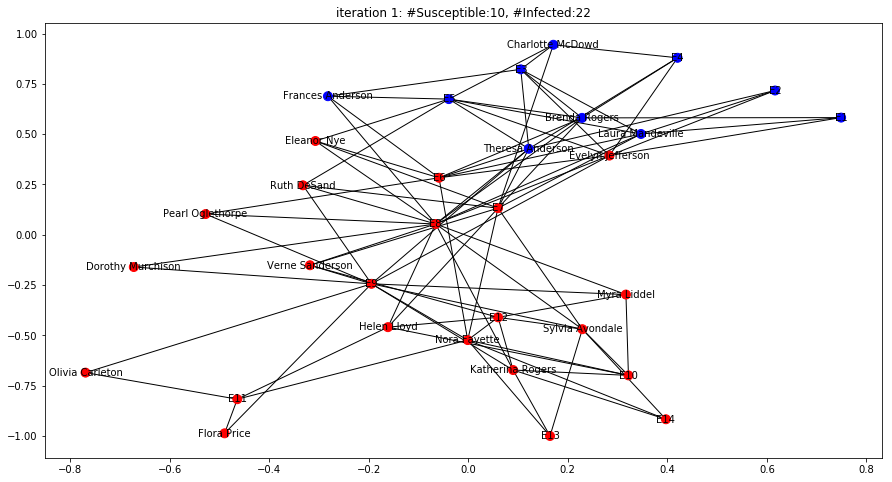

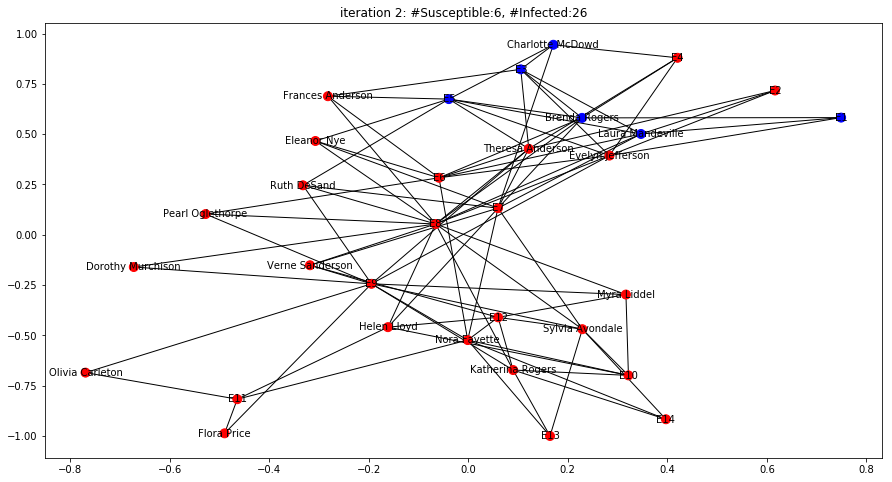

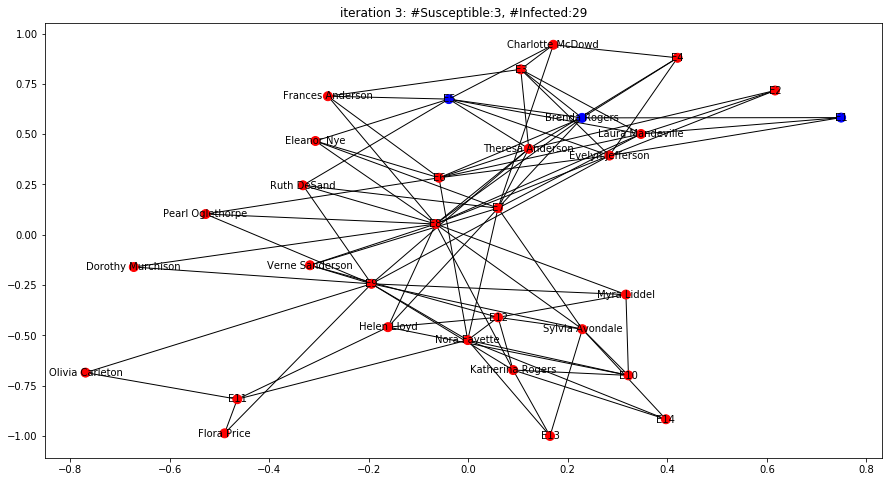

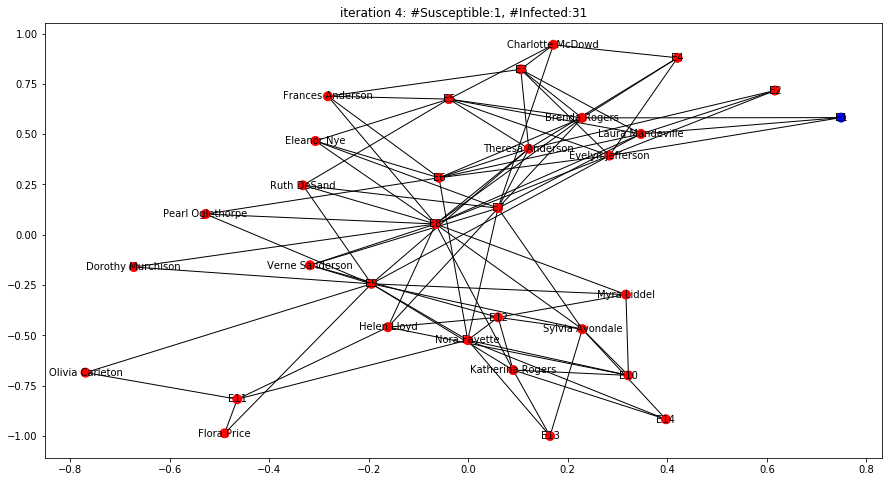

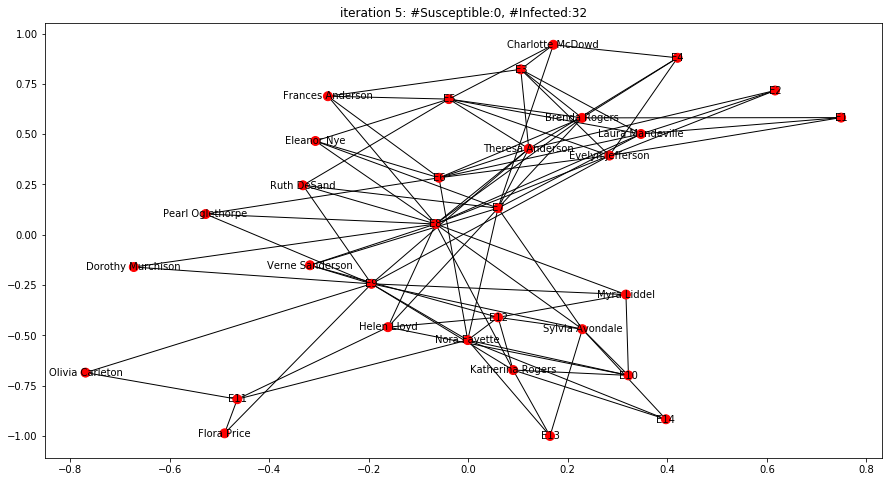

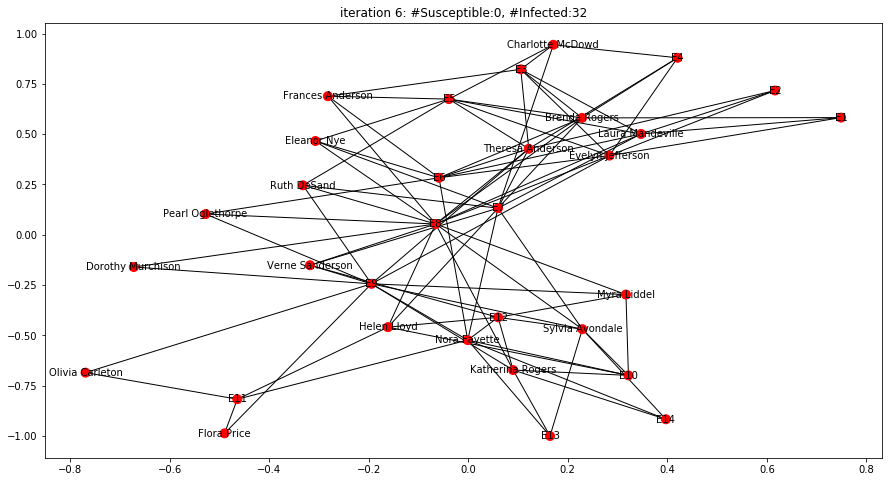

In [64]:
spread_contagion(labels, q_equal)